### Try-It Activity 22.1: Visualizing Convolutional Layers

This try-it offers the opportunity to explore the feature maps learned by a large convolutional network.  Any of the pre-trained networks available in the `keras.applications` or even a network you train yourself using convolutional layers can be interrogated to explore the learned feature maps.  Your goal is to use the documentation example from `keras` [here](https://keras.io/examples/vision/visualizing_what_convnets_learn/) to explore the layers of either a pre-trained convolutional network or one that you train yourself on a dataset of your choosing.

#### `ResNet50` Example

Consult the documentation [here](https://keras.io/examples/vision/visualizing_what_convnets_learn/) to get started visualizing the feature maps from the `ResNet50` model.  Select a different pre-trained architecture from `keras.applications` (list [here](https://keras.io/api/applications/)), and try to replicate the layer visualizations.  Share your results with your classmates.  

58889256/58889256 [==============================] - 1s 0us/step
Visualizing filter 0 in layer: block3_conv3
Filter visualization saved to filter_0.png
Processing first 16 filters...
Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Visualization grid saved to stitched_filters.png
Visualization also saved as vgg16_filter_visualization.png


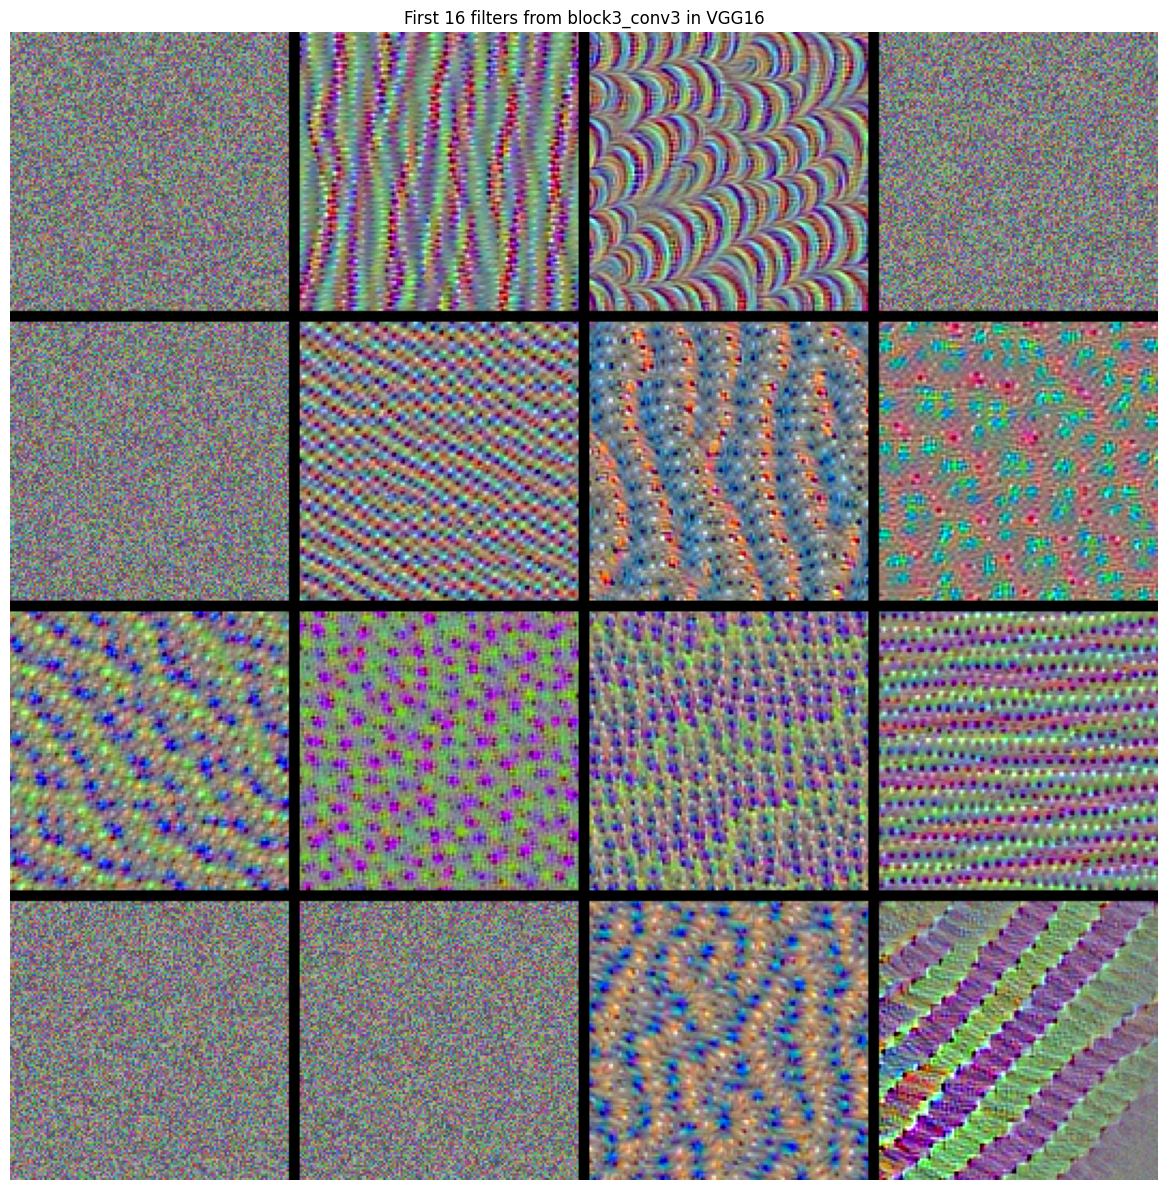

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Image, display

# The dimensions of our input image
img_width = 180
img_height = 180
# Our target layer: we will visualize the filters from this layer
layer_name = "block3_conv3"  # Using a middle layer from VGG16

# Build a VGG16 model loaded with pre-trained ImageNet weights
model = keras.applications.VGG16(weights="imagenet", include_top=False)

# Set up a model that returns the activation values for our target layer
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients
    grads = tape.gradient(loss, img)
    # Normalize gradients
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # VGG16 expects inputs in the range [0, 255] with the standard RGB channel mean values subtracted
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25

def visualize_filter(filter_index):
    # We run gradient ascent for 30 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img

def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

# Visualize a single filter
print("Visualizing filter 0 in layer:", layer_name)
loss, img = visualize_filter(0)
keras.utils.save_img("filter_0.png", img)
print(f"Filter visualization saved to filter_0.png")

# Create a grid of the first 16 filters (4x4 grid)
print("Processing first 16 filters...")
all_imgs = []
for filter_index in range(16):
    print(f"Processing filter {filter_index}")
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 4 x 4 filters of size 130 x 130, with a 5px margin in between
margin = 5
n = 4
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j + cropped_height,
            :,
        ] = img

keras.utils.save_img("stitched_filters.png", stitched_filters)
print("Visualization grid saved to stitched_filters.png")

# Display the filters grid using matplotlib if running in a notebook environment
plt.figure(figsize=(12, 12))
plt.imshow(stitched_filters.astype('uint8'))
plt.title(f"First 16 filters from {layer_name} in VGG16")
plt.axis('off')
plt.tight_layout()
plt.savefig("vgg16_filter_visualization.png")
print("Visualization also saved as vgg16_filter_visualization.png")

# Module 22 - Visualizing CNN Filters

## Summary
This notebook demonstrates how to visualize what convolutional neural network (CNN) filters are "looking for" by using gradient ascent to generate images that maximally activate specific filters. This technique helps in understanding and interpreting what features the CNN has learned to detect.

## Key Components

1. **Model Setup**
   - Uses a pre-trained VGG16 model loaded with ImageNet weights
   - Removes the top classification layers to focus on convolutional features

2. **Filter Visualization Technique**
   - Implements gradient ascent optimization to generate images that maximize filter activations
   - Starts with random noise images and gradually modifies them to increase filter responses
   - Includes preprocessing and deprocessing functions to handle image transformations

3. **Visualization Process**
   - Defines a `visualize_filter` function that performs gradient ascent to maximize activation of a specific filter
   - Uses TensorFlow's GradientTape API to compute gradients
   - Applies normalization, centering, and clipping to make visualizations interpretable

4. **Output Generation**
   - Creates individual filter visualizations
   - Generates a grid display of multiple filters to compare their patterns
   - Saves the visualizations as PNG images

## Key Takeaways

1. CNN filters in early layers detect simple features like edges, colors, and textures
2. Deeper layers combine these features to detect more complex patterns
3. Visualizing filters helps interpret what the CNN "sees" and how it makes decisions
4. Gradient ascent is a powerful technique for generating visualizations that maximally activate specific network components
5. The VGG16 architecture has specialized filters that respond to different visual features
6. Understanding filter activations can help in diagnosing and improving CNN performance

## Technical Concepts Demonstrated

- Gradient computation in TensorFlow
- Image processing and normalization techniques
- CNN architecture exploration
- Feature visualization for interpretability